In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-jax/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [4]:
import matplotlib.colors as mcolors

In [5]:
# https://www.youtube.com/watch?v=scvuli-zcRc&t=3s

In [62]:
n_particles = 256
n_colors = 6
n_dims = 2

# dt = 0.02
dt = 0.002
half_life = 0.04
rmax = 0.1

# NOTE: the actual space is [0, 1]

def get_random_env_params(rng):
    beta = 0.3
    # alphas = jax.random.normal(rng, (n_colors, n_colors))
    alphas = jax.random.uniform(rng, (n_colors, n_colors), minval=-1., maxval=1.)
    masses = jnp.ones((n_colors, ))/10.
    return dict(alphas=alphas, beta=beta, masses=masses)

def calc_force(r, alpha, beta):
    first = r / beta - 1
    second = alpha * (1 - jnp.abs(2 * r - 1 - beta) / (1 - beta))
    cond_first = (r < beta) # (0 <= r) & (r < beta)
    cond_second = (beta < r) & (r < 1)
    return jnp.where(cond_first, first, jnp.where(cond_second, second, 0.))

def get_random_init_state(rng):
    rng, _rng = split(rng)
    c = jax.random.randint(_rng, (n_particles,), 0, n_colors)
    rng, _rng = split(rng)
    x = jax.random.uniform(_rng, (n_particles, n_dims), minval=0, maxval=1)
    v = jnp.zeros((n_particles, n_dims))
    return dict(c=c, x=x, v=v)

def forward_step(rng, state, env_params):
    x, v, c = state['x'], state['v'], state['c']
    alphas, beta, masses = env_params['alphas'], env_params['beta'], env_params['masses']

    mass = masses[c]

    # index alphas using all pairwise colors, code looks weird, but works
    alpha = alphas[c[:, None], c[None, :]] # (N, N)
    r = x[None, :, :] - x[:, None, :] # (N, N, D)
    # r = jnp.minimum(r, 1.-r) # circular boundary this is wrong tho
    # r = jax.lax.select(r<0.5, r%1., (-r)%1.) # circular boundary
    r = jax.lax.select(r>0.5, r-1, jax.lax.select(r<-0.5, r+1, r))
    


   

    # print(r[2, 4], (x[4] - x[2]))
    # print(alpha[2,4], alphas[c[2], c[4]])
    rlen = jnp.linalg.norm(r, axis=-1)

    # double vmap for pairwise (N, N) interactions
    f = jax.vmap(jax.vmap(partial(calc_force, beta=beta)))(rlen/rmax, alpha)
    f = r/(rlen[..., None]+1e-8) * f[..., None]
    # f = f.at[jnp.arange(n_particles), jnp.arange(n_particles)].set(0.) # uneeded if adding epsilon term
    
    f = rmax * jnp.sum(f, axis=1)
    acc = f / mass[:, None]
    
    mu = (0.5) ** (dt / half_life)
    v = mu * v + acc * dt
    x = x + v * dt

    x = x%1. # circular boundary
    return dict(c=c, x=x, v=v)

def render_state(state):
    x, v, c = state['x'], state['v'], state['c']
    for ci in range(n_colors):
        plt.scatter(*x[c==ci].T, s=1.)
    plt.xlim(-0.0, 1.0)
    plt.ylim(-0.0, 1.0)

In [63]:
rng = jax.random.PRNGKey(1)
env_params = get_random_env_params(rng)

state = get_random_init_state(rng)

state = forward_step(rng, state, env_params)

  0%|          | 0/16 [00:00<?, ?it/s]

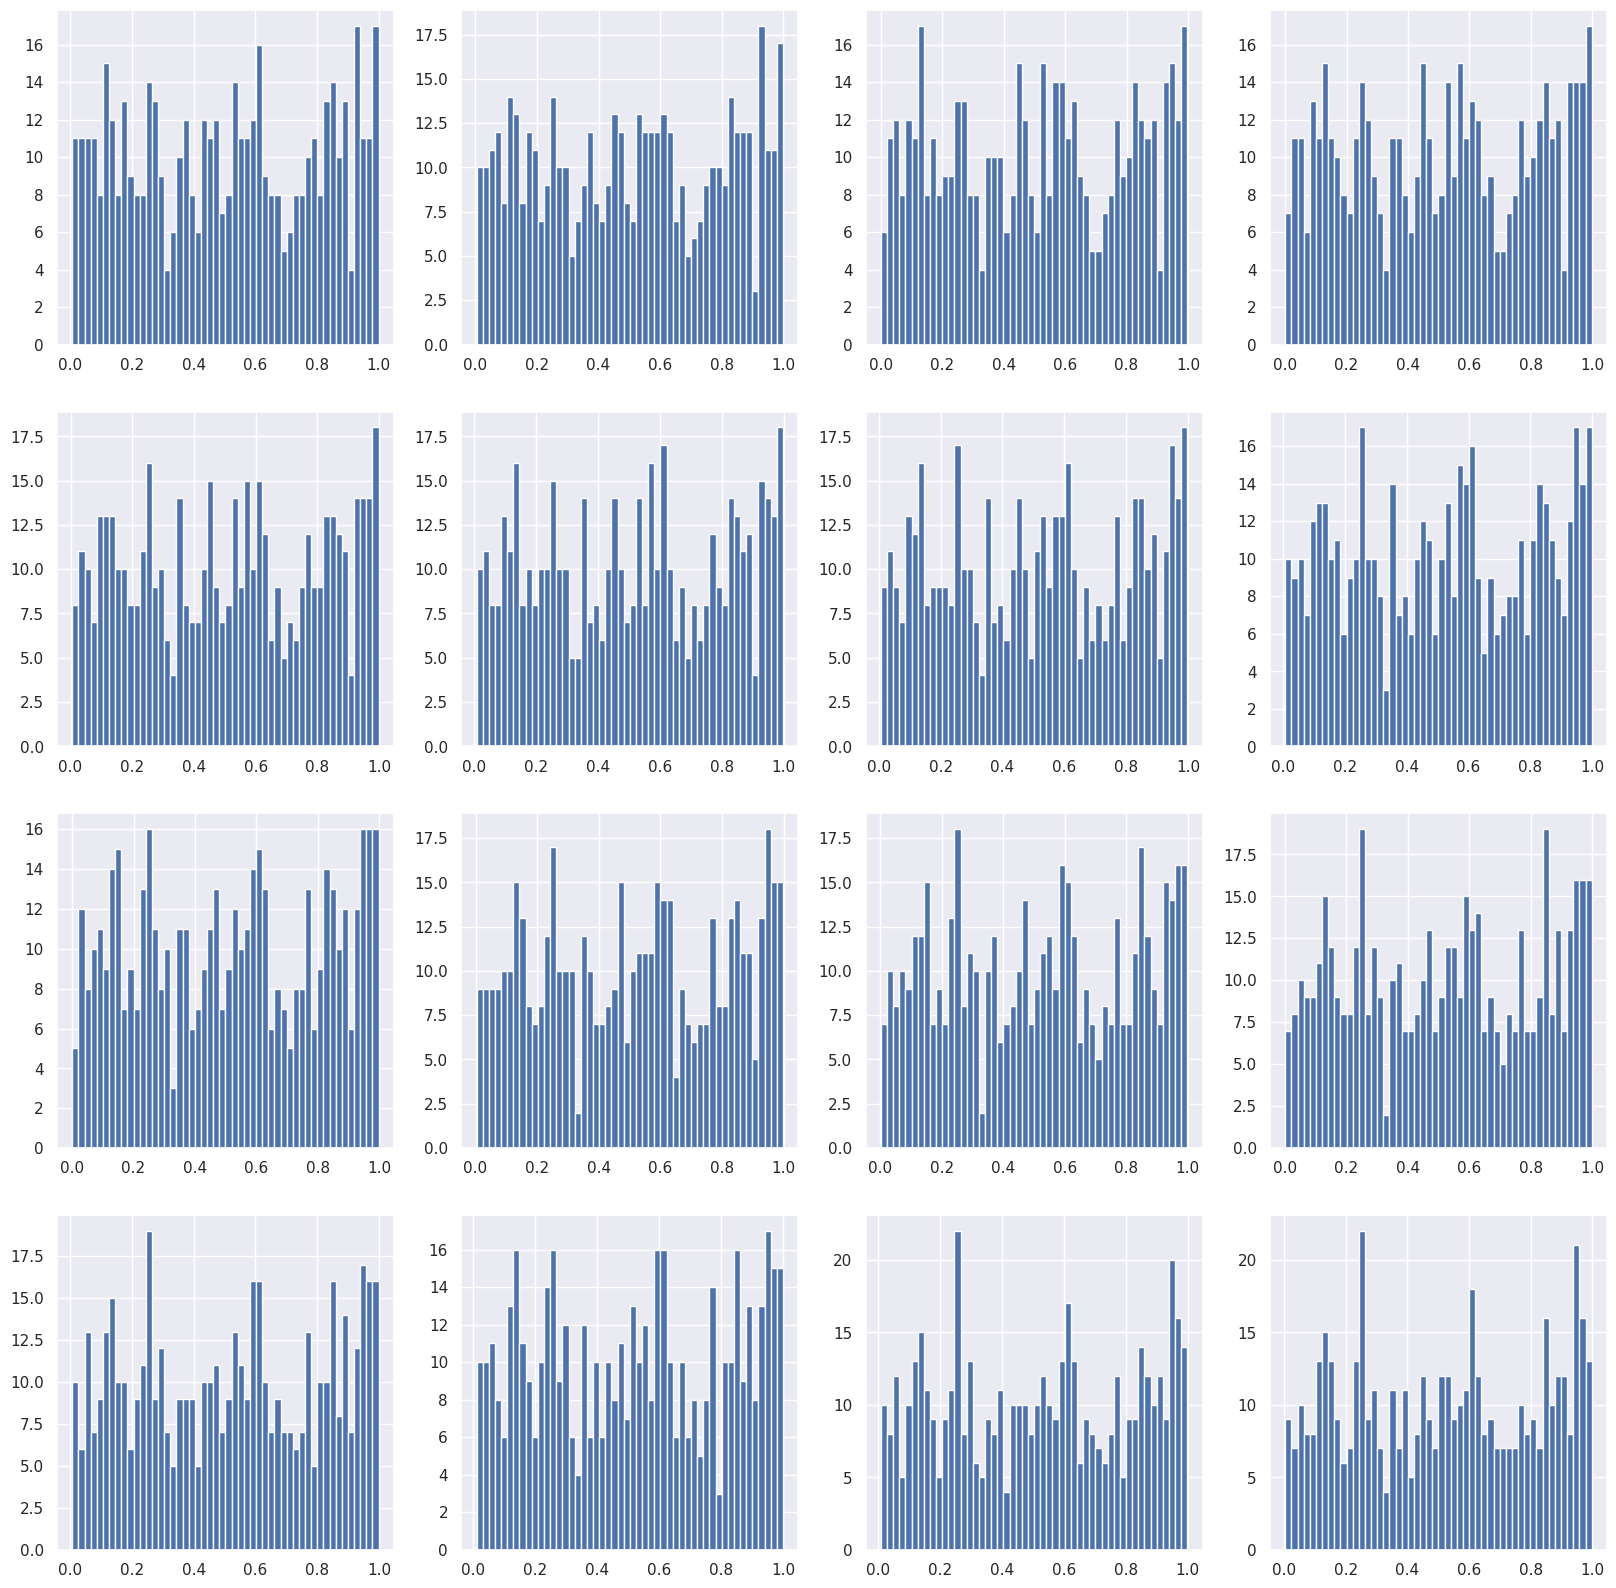

In [64]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
env_params = get_random_env_params(_rng)

rng, _rng = split(rng)
state = get_random_init_state(_rng)

@jax.jit
def forward_step_mine(state, _):
    state = forward_step(None, state, env_params)
    return state, state


plt.figure(figsize=(20, 20))
for i in tqdm(range(16)):
    plt.subplot(4, 4, i+1)
    # render_state(state)
    plt.hist(state['x'].flatten(), bins=50);
    
    state, vid = jax.lax.scan(forward_step_mine, state, length=100)


In [56]:
rng = jax.random.PRNGKey(0)
rng, _rng = split(rng)
env_params = get_random_env_params(_rng)

def get_it(rng):
    rng, _rng = split(rng)
    state = get_random_init_state(_rng)
    @jax.jit
    def forward_step_mine(state, _):
        state = forward_step(None, state, env_params)
        return state, state
    state, vid = jax.lax.scan(forward_step_mine, state, length=10000)
    return state


state = jax.vmap(get_it)(split(rng, 1000))

2024-07-06 04:25:21.938378: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 11.06GiB (11872237932 bytes) by rematerialization; only reduced to 48.18GiB (51733504108 bytes), down from 48.18GiB (51733504108 bytes) originally


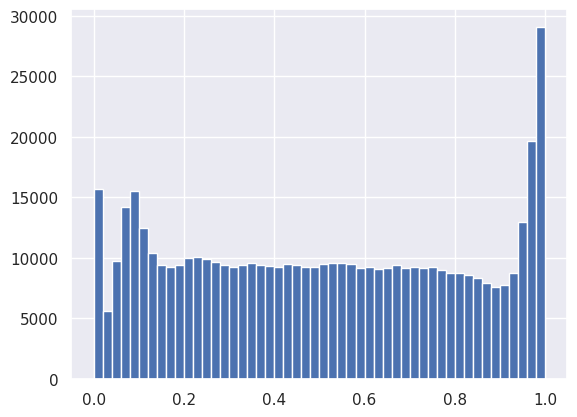

In [60]:
plt.hist(state['x'].flatten(), bins=50);

In [16]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])


[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725), (0.8666666666666667, 0.5176470588235295, 0.3215686274509804), (0.3333333333333333, 0.6588235294117647, 0.40784313725490196), (0.7686274509803922, 0.3058823529411765, 0.3215686274509804), (0.5058823529411764, 0.4470588235294118, 0.7019607843137254), (0.5764705882352941, 0.47058823529411764, 0.3764705882352941), (0.8549019607843137, 0.5450980392156862, 0.7647058823529411), (0.5490196078431373, 0.5490196078431373, 0.5490196078431373), (0.8, 0.7254901960784313, 0.4549019607843137), (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]


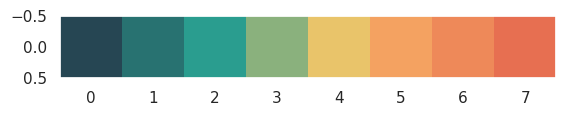

In [17]:
colors = '264653-287271-2a9d8f-8ab17d-e9c46a-f4a261-ee8959-e76f51'.split('-')
colors = np.array([mcolors.to_rgba(f"#{a}") for a in colors])
plt.imshow(colors[None, :, :])
plt.grid(False)

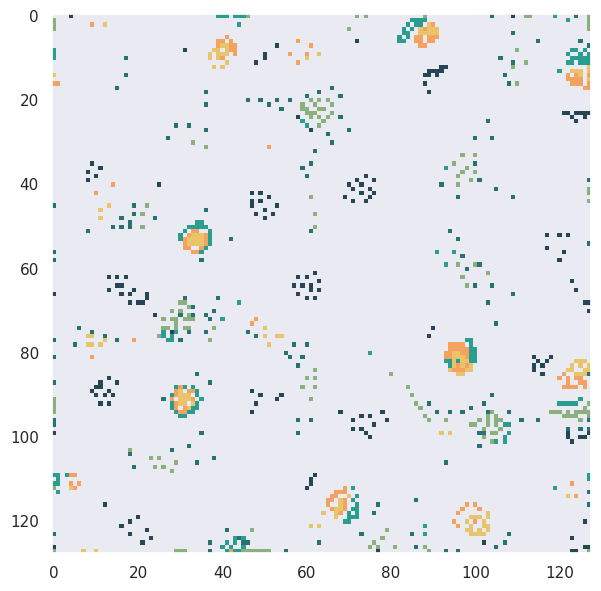

In [18]:
def render_state(state, img_size=128, particle_size=1):
    pos, vel, pcol = state['x'], state['v'], state['c']
    
    img = jnp.zeros((img_size, img_size, 4))
    xmid, ymid = (pos.T*img_size).astype(int)
    x, y = [], []
    radius = particle_size//2
    for i in range(-radius, radius+1):
        for j in range(-radius, radius+1):
            x.append(xmid+i)
            y.append(ymid+j)
    x, y = jnp.concatenate(x), jnp.concatenate(y)
    color = colors[pcol]
    color = repeat(color, "N D -> (K N) D", K=particle_size**2)
    img = img.at[x, y, :].set(color)
    return img

img = render_state(state)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.grid(False)


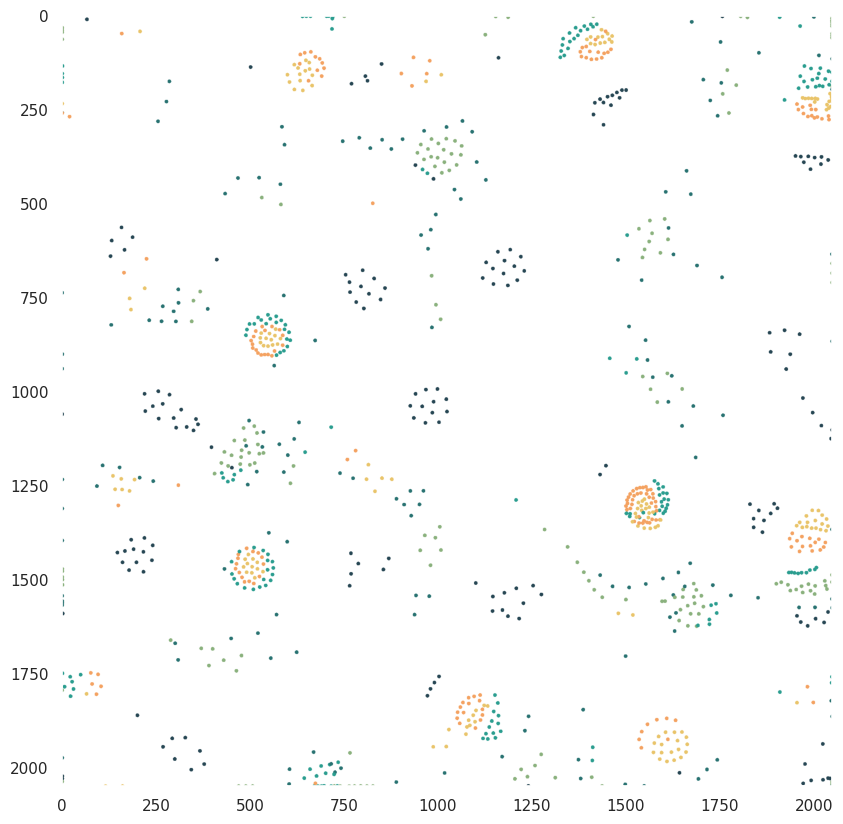

In [50]:
def render_state_heavy(state, img_size=256, radius=10):
    pos, vel, pcol = state['x'], state['v'], state['c']

    img = jnp.ones((img_size, img_size, 4))

    xgrid = ygrid = jnp.arange(img_size)
    xgrid, ygrid = jnp.meshgrid(xgrid, ygrid, indexing='ij')

    def render_circle(img, circle_data):
        x, y, radius, color = circle_data
        d2 = (x-xgrid)**2 + (y-ygrid)**2
        d2 = (d2<radius**2).astype(jnp.float32)[:, :, None]

        # print(d2.shape)
        # print(img.shape)
        # print(color.shape)
        img = d2*color + (1.-d2)*img
        return img, None

    x, y = pos.T * img_size
    radius = jnp.full(x.shape, fill_value=radius)
    color = colors[pcol]
    img, _ = jax.lax.scan(render_circle, img, (x, y, radius, color))
    return img

img = render_state_heavy(state, img_size=2048, radius=5)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)


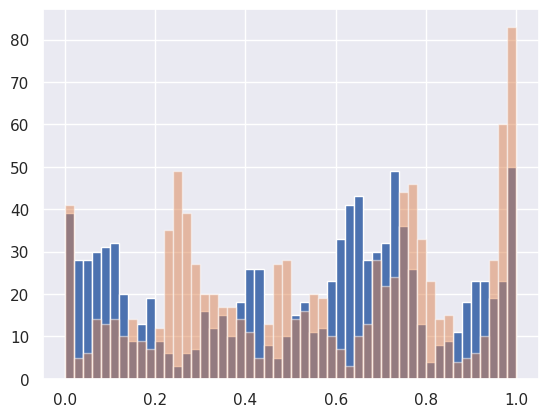

In [38]:
plt.hist(state['x'][:, 0].flatten(), bins=50, alpha=1.0);
plt.hist(state['x'][:, 1].flatten(), bins=50, alpha=0.5);

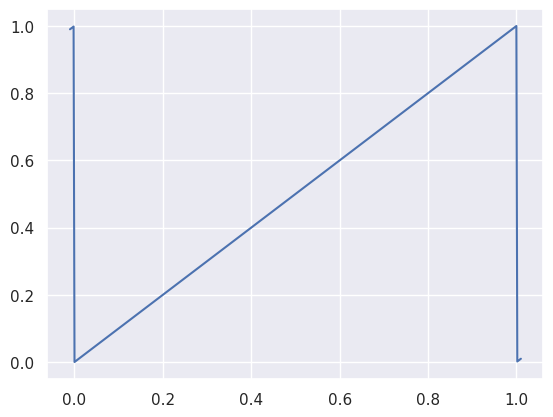

In [45]:
a = jnp.linspace(-0.01, 1.01, 500)
plt.plot(a, a%1.)

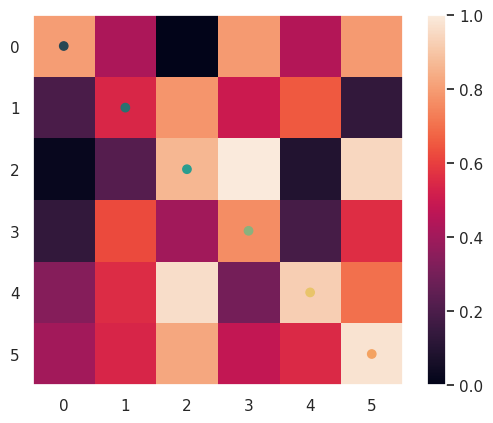

In [94]:
plt.imshow(env_params['alphas'])
plt.scatter(np.arange(n_colors), np.arange(n_colors), c=colors[:n_colors])
plt.grid(False)
plt.colorbar()

In [231]:
jax.tree.map(lambda x: x.shape, vid)

{'c': (10000, 1000), 'v': (10000, 1000, 2), 'x': (10000, 1000, 2)}

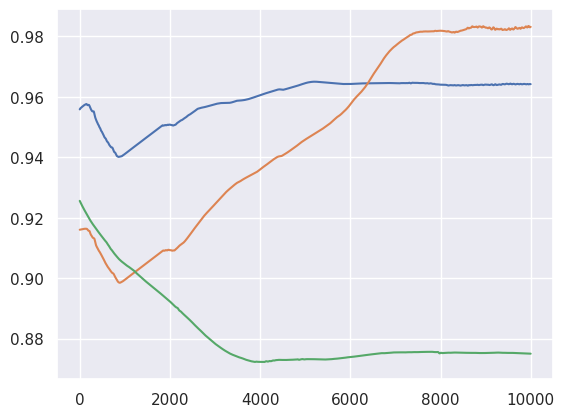

In [242]:
plt.plot(vid['x'][:, :3, 0])

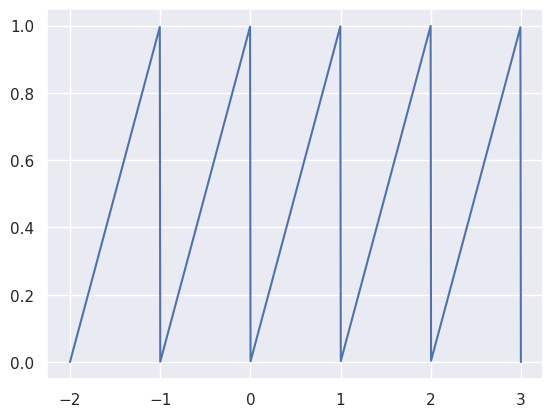

In [264]:
x = jnp.linspace(-2, 3, 1000)
y = x%1
plt.plot(x, y)

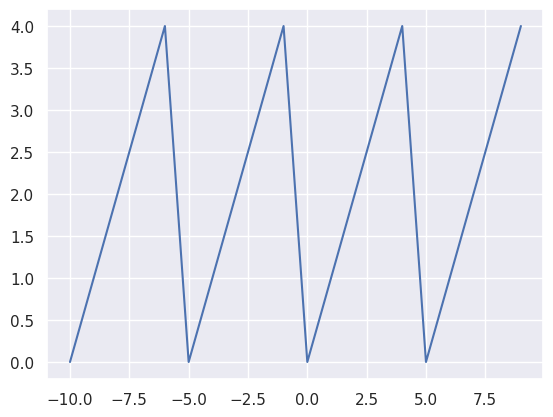

In [266]:
x = jnp.arange(-10, 10)
y = x%5
plt.plot(x, y)

[[-0.         -0.32587138 -0.11319419 -0.2517466  -0.39370623]
 [-0.2581752  -0.          0.33277568 -0.16534513  0.23724943]
 [ 0.11319419 -0.33277568 -0.         -0.00355801  0.7916105 ]
 [ 0.2517466  -0.20870033 -0.00449096 -0.         -0.21128696]
 [-0.09780009  0.07047719  0.23515536 -0.05248553 -0.        ]]


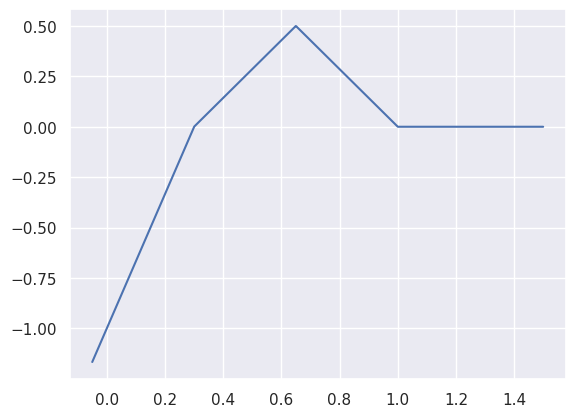

In [91]:
x = jnp.linspace(-0.05, 1.5, 1000)
y = jax.vmap(partial(calc_force, alpha=0.5, beta=0.3))(x)
plt.plot(x, y)

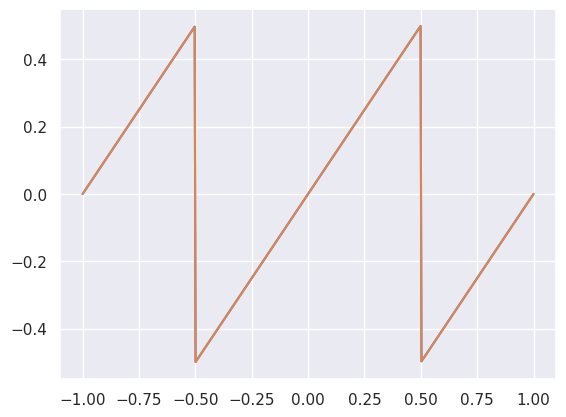

In [80]:
r = jnp.linspace(-1., 1., 500)

v = jax.lax.select(jnp.abs(r)<0.5, r, jax.lax.select(r>0, r-1, r+1))
plt.plot(r, v)

v = jax.lax.select(r>0.5, r-1, jax.lax.select(r<-0.5, r+1, r))
plt.plot(r, v)

In [35]:
def temp(state, _rng):
    state = forward_state(_rng, state, env_params)
    return state, None


a, _ = jax.lax.scan(temp, state, split(rng, 1000000))

In [36]:
a['x'].max()

Array(6849.4443, dtype=float32)

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000,) (8, 8)
(1000, 1000)


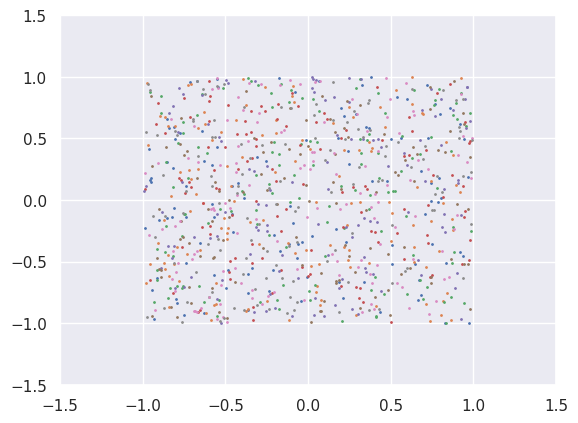

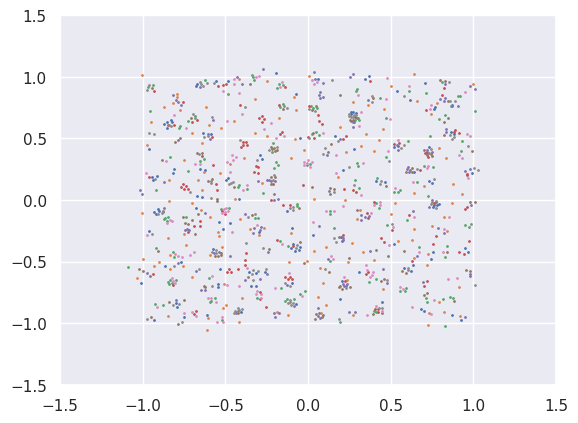

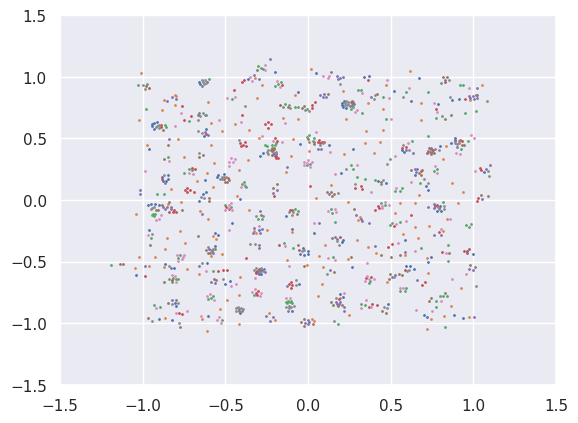

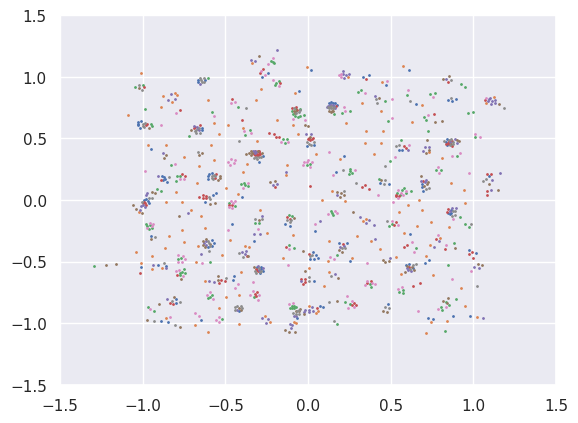

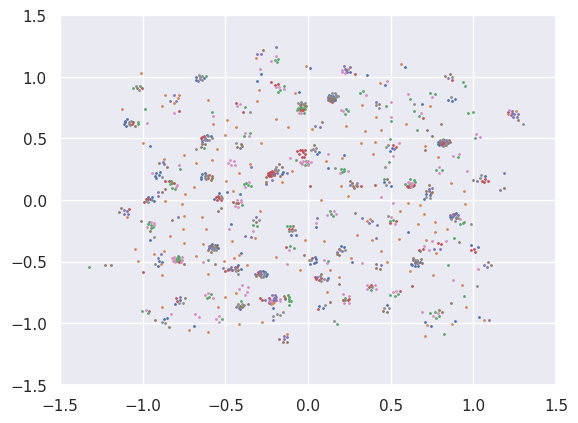

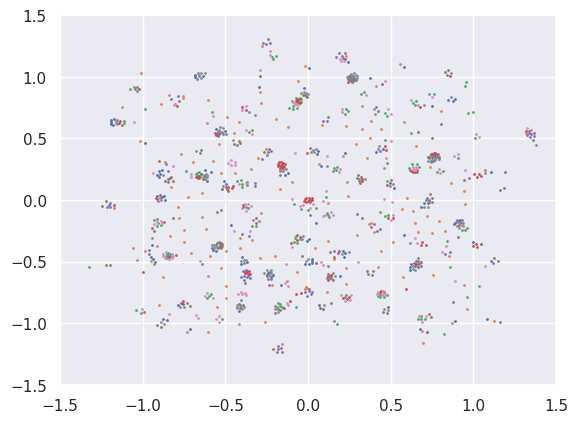

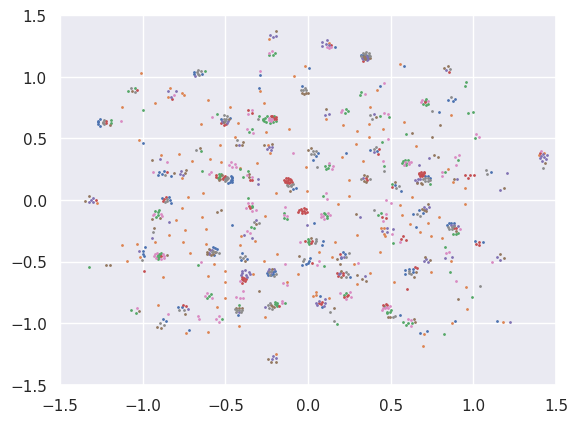

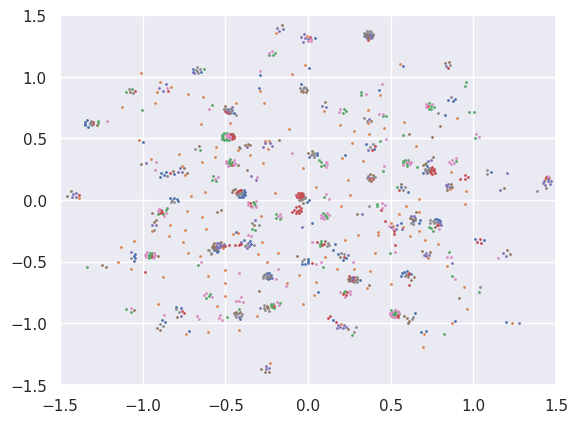

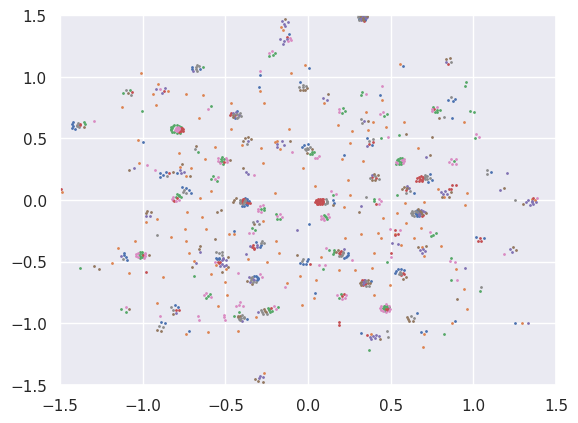

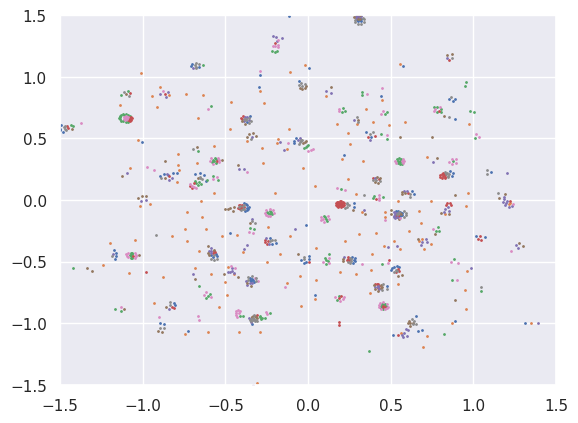

In [24]:
rng = jax.random.PRNGKey(1)

rng, _rng = split(rng)
env_params = init_env_params(_rng)
rng, _rng = split(rng)
state = init_state(_rng)

for i in tqdm(range(1000)):
    rng, _rng = split(rng)
    state = forward_state(_rng, state, env_params)
    if i % 100 == 0:
        render_state(state)
        plt.show()

In [70]:
from particle_life_jax import ParticleLife

In [71]:
plife = ParticleLife(1000, 4)

rng = jax.random.PRNGKey(0)
env_params = plife.get_random_env_params(rng)
state = plife.get_random_init_state(rng)

In [72]:
def forward_chunk(state, env_params, n_steps=1024):
    def forward_step(state, _):
        state = plife.forward_step(state, env_params)
        return state, state
    return jax.lax.scan(forward_step, state, None, length=n_steps)

In [73]:
state, vid = forward_chunk(state, env_params)

In [80]:
jax.tree.map(lambda x: x.shape, vid)

{'c': (1024, 1000), 'v': (1024, 1000, 2), 'x': (1024, 1000, 2)}

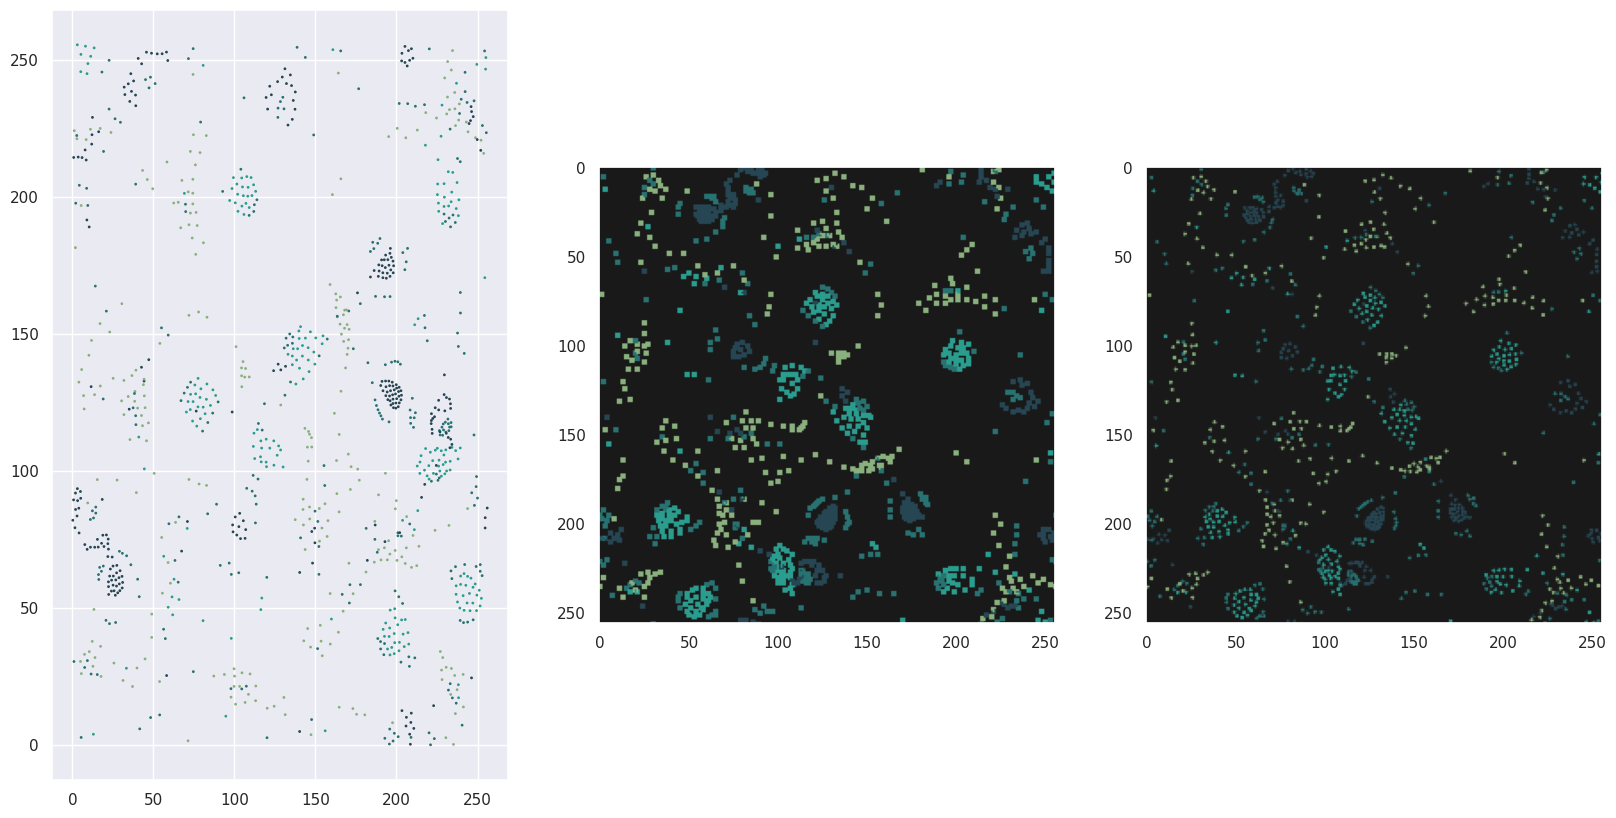

In [76]:
plt.figure(figsize=(20, 10))
plt.subplot(131)
plife.render_state_mpl(state, radius=1)
plt.subplot(132)
plt.imshow(plife.render_state_light(state, radius=1))
plt.grid(False)
plt.subplot(133)
plt.imshow(plife.render_state_heavy(state, radius=1., blur=10))
plt.grid(False)